# Config

Refernce:

- https://www.kaggle.com/competitions/dog-breed-identification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
with zipfile.ZipFile("drive/My Drive/AI_practice/Computer Vision/dog_breed_classification/train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/train/")

with zipfile.ZipFile("drive/My Drive/AI_practice/Computer Vision/dog_breed_classification/test.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/test/")

Mounted at /content/drive


In [ ]:
!pip install   ipython-autotime
!pip install -q lightning

%load_ext autoreload
%autoreload 2
%load_ext sql
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import glob
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import torch
import torchvision
import torchmetrics
import torchsummary
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
INPUT_SIZE = 224
NUM_CLASSES = 120

data_dir = 'drive/My Drive/AI_practice/Computer Vision/dog_breed_classification/'
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
print(len(os.listdir('/content/train/')), len(labels))
print(len(os.listdir('/content/test/')), len(sample_submission))

10222 10222
10357 10357


In [ ]:
display(labels["id"].nunique(), labels["breed"].nunique())
labels["breed"].value_counts()

10222

120

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


In [ ]:
# def get_path(path, labels_list, label_to_index):
#     paths = []
#     for name in labels_list:
#         # Get all .png file paths in the directory for the current label
#         file_paths = glob.glob(f"{path}{name}/*.jpg")

#         # Append each image's details to paths list
#         for file_path in file_paths:
#             paths.append({
#                 "name": name,
#                 "path": file_path,
#                 "label": label_to_index[name]
#             })
#     return paths

# val_path = "/content/test/"

# # Path to the training dataset
# train_path = "/content/train/"

# list_ = [name for name in os.listdir(train_path)]
# # Mapping each label name to a unique integer index
# label_to_index = {}
# for index, label in enumerate(list_):
#     label_to_index[label] = index

# train_paths = get_path(train_path, list_, label_to_index)
# val_paths = get_path(val_path, list_, label_to_index)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = os.path.join(self.root_dir, img_name)
        image = Image.open(fullname)
        # image = torchvision.io.read_image(fullname)
        # labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = self.labels.iloc[idx, :].to_numpy().astype('bool')
        labels = selected_columns = self.labels.columns[labels].tolist()
        labels = torch.tensor(np.argmax(labels))
        if self.transform:
            image = self.transform(image)
        return {"image": image, "label": labels}

class DataModule(L.LightningDataModule):
    def __init__(
            self, batch_size, num_workers, df_labels: pd.DataFrame = None,
            train_path = None, val_path = None, transform = None
    ):
        super(DataModule, self).__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.train_path = train_path
        self.val_path = val_path
        # self.test_path = self.test_path
        self.df_labels = df_labels

    def setup(self, stage=None):

        if self.df_labels.shape[0] > 0:
            self.df_labels['target'] = 1
            self.df_labels['rank'] = self.df_labels.groupby('breed').rank()['id']
            labels_pivot = pd.pivot_table(
                self.df_labels,
                index="id",
                columns="breed",
                values="target",
                fill_value=0,
            ).reset_index()
            train_df = labels_pivot.sample(frac=0.8)
            val_df = labels_pivot[~labels_pivot['id'].isin(train_df['id'])]

        # if self.df_label is None:
        #     train_paths = get_path(self.train_path, list_, label_to_index)  # Get training paths
        #     val_paths = get_path(self.val_path, list_, label_to_index)      # Get validation paths
        #     val_paths = self.val_path
        #     train_paths, test_paths = train_test_split(self.train_path, test_size = 0.2, random_state = 0)

        train_paths = self.train_path
        val_paths = self.train_path
        self.train_dataset = Dataset(train_df, train_paths, transform = self.transform)
        self.val_dataset = Dataset(val_df, val_paths, transform = self.transform)
        # self.test_dataset = Dataset(test_df, transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )

In [ ]:
ds_trans = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                               torchvision.transforms.CenterCrop(224),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]
                              )
])

data_module = DataModule(128, 2, df_labels = labels, train_path = "/content/train/",transform = ds_trans)
data_module.setup()

train_loader = data_module.train_dataloader()

torch.Size([128, 3, 224, 224]) torch.Size([128])


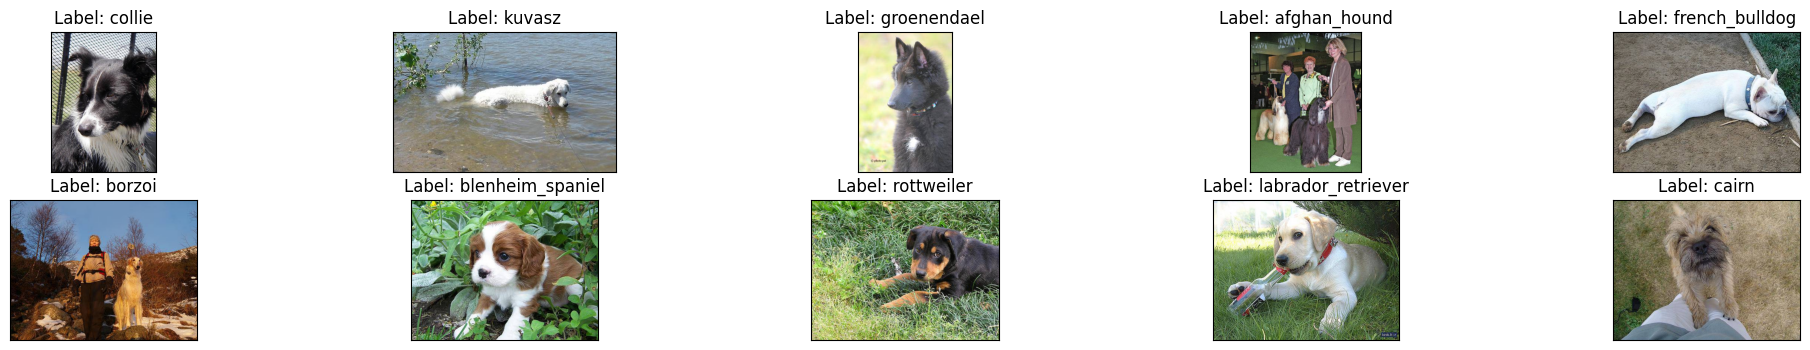

In [ ]:
img_input = next(iter(train_loader))["image"]
labels_output = next(iter(train_loader))["label"]
print(img_input.size(), labels_output.size())

fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im_plot = Image.open("train/" + img)
    plt.imshow(im_plot)

    lab = labels.loc[labels['id'] == img.split('.')[0], 'breed'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:
class Model(L.LightningModule):
    def __init__(self, is_train=False, learning_rate=1e-3, num_target_classes=4):
        super(Model, self).__init__()

        # Load the pretrained  model
        backbone = torchvision.models.resnet50(weights="DEFAULT")

        # Number of filters in the final fully connected layer of ResNet50
        num_filters = backbone.fc.in_features

        # Remove last classification layer
        layers = list(backbone.children())[:-1]

        # Define the feature extractor and classifier
        self.feature_extractor = torch.nn.Sequential(*layers)
        self.classifier = torch.nn.Linear(num_filters, num_target_classes)

        # Model training parameters
        self.is_train = is_train
        self.learning_rate = learning_rate

        # Loss function and metric
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_target_classes)

    def forward(self, x):
        """
        Defines the forward pass for the model.

        Args:
            x (Tensor): Input tensor (batch of images).

        Returns:
            Tensor: Output tensor (logits for each class).
        """
        # Set feature extractor to evaluation mode
        self.feature_extractor.eval()

        # Extract features
        if self.is_train:
            representations = self.feature_extractor(x).flatten(1)
        else:
            # Disable gradient calculations for inference
            with torch.no_grad():
                representations = self.feature_extractor(x).flatten(1)

        # Classify the representations
        x = self.classifier(representations)
        return x

    def training_step(self, batch, batch_idx):
        """
        Training step for a batch.

        Args:
            batch (dict): Batch of data, containing images and labels.
            batch_idx (int): Index of the batch.

        Returns:
            Tensor: Training loss for the batch.
        """
        x = batch["image"]
        y = batch["label"]

        # Forward pass
        y_pred = self(x)

        # Calculate loss and accuracy
        loss = self.loss(y_pred, y)
        acc = self.accuracy(y_pred, y)

        # Log metrics
        self.log_dict({'train_loss': loss, 'train_acc': acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]

        # Forward pass
        y_pred = self(x)

        # Calculate loss and accuracy
        val_loss = self.loss(y_pred, y)
        val_acc = self.accuracy(y_pred, y)

        # Log metrics
        self.log_dict({'val_loss': val_loss, 'val_acc': val_acc}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]

        # Forward pass
        y_pred = self(x)

        # Calculate loss and accuracy
        test_loss = self.loss(y_pred, y)
        test_acc = self.accuracy(y_pred, y)

        # Log metrics
        self.log_dict({'test_loss': test_loss, 'test_acc': test_acc}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        """
        Predict step for a batch, used for generating predictions.

        Args:
            batch (dict): Batch of data, containing images.
            batch_idx (int): Index of the batch.
            dataloader_idx (int, optional): Index of the dataloader (for multi-dataloader scenarios).

        Returns:
            None: Implement prediction logic as needed.
        """
        x = batch["image"]
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        """
        Sets up the optimizer for the model.

        Returns:
            Optimizer: Adam optimizer with the specified learning rate.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
model_checkpoint = ModelCheckpoint(
    dirpath='checkpoint/',        # Directory to save the checkpoints
    monitor="val_acc",           # Metric to monitor for checkpointing
    verbose=True,                # Print messages when saving a checkpoint
    mode="max",                  # Save the checkpoint with the maximum validation accuracy
    save_top_k=1                 # Save only the best model
)
early_stopping = EarlyStopping(
    monitor="val_acc",           # Metric to monitor for early stopping
    mode="max",                  # Stop training when the validation accuracy stops improving
    min_delta=1e-4,              # Minimum change to qualify as an improvement
    patience=5                   # Number of epochs with no improvement after which training will be stopped
)
model = Model(is_train = False)

data_module = DataModule(128, 2, df_labels = labels, train_path = "/content/train/",transform = ds_trans)
data_module.setup()

# Create the PyTorch Lightning Trainer with specified parameters
trainer = L.Trainer(
    max_epochs=50,                                  # Maximum number of training epochs
    detect_anomaly=True,                            # Enable anomaly detection for debugging
    callbacks=[model_checkpoint, early_stopping]    # Register the callbacks for training
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.5MB/s]
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M | train
1 | classifier        | Linear             | 8.2 K  | train
2 | loss              | CrossEntropyLoss   | 0      | train
3 | accuracy          | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M | train
1 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 64: 'val_acc' reached 0.81311 (best 0.81311), saving model to '/content/checkpoint/epoch=0-step=64.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 64: 'val_acc' reached 0.81311 (best 0.81311), saving model to '/content/checkpoint/epoch=0-step=64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 128: 'val_acc' reached 0.85910 (best 0.85910), saving model to '/content/checkpoint/epoch=1-step=128.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 128: 'val_acc' reached 0.85910 (best 0.85910), saving model to '/content/checkpoint/epoch=1-step=128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 192: 'val_acc' reached 0.88258 (best 0.88258), saving model to '/content/checkpoint/epoch=2-step=192.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 192: 'val_acc' reached 0.88258 (best 0.88258), saving model to '/content/checkpoint/epoch=2-step=192.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 256: 'val_acc' reached 0.89677 (best 0.89677), saving model to '/content/checkpoint/epoch=3-step=256.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 256: 'val_acc' reached 0.89677 (best 0.89677), saving model to '/content/checkpoint/epoch=3-step=256.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 320: 'val_acc' reached 0.90313 (best 0.90313), saving model to '/content/checkpoint/epoch=4-step=320.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 320: 'val_acc' reached 0.90313 (best 0.90313), saving model to '/content/checkpoint/epoch=4-step=320.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 384: 'val_acc' reached 0.91145 (best 0.91145), saving model to '/content/checkpoint/epoch=5-step=384.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 384: 'val_acc' reached 0.91145 (best 0.91145), saving model to '/content/checkpoint/epoch=5-step=384.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 448: 'val_acc' reached 0.91341 (best 0.91341), saving model to '/content/checkpoint/epoch=6-step=448.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 448: 'val_acc' reached 0.91341 (best 0.91341), saving model to '/content/checkpoint/epoch=6-step=448.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 512: 'val_acc' reached 0.91438 (best 0.91438), saving model to '/content/checkpoint/epoch=7-step=512.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 512: 'val_acc' reached 0.91438 (best 0.91438), saving model to '/content/checkpoint/epoch=7-step=512.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 576: 'val_acc' reached 0.91732 (best 0.91732), saving model to '/content/checkpoint/epoch=8-step=576.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 576: 'val_acc' reached 0.91732 (best 0.91732), saving model to '/content/checkpoint/epoch=8-step=576.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 640: 'val_acc' reached 0.91830 (best 0.91830), saving model to '/content/checkpoint/epoch=9-step=640.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 640: 'val_acc' reached 0.91830 (best 0.91830), saving model to '/content/checkpoint/epoch=9-step=640.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.validate(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9368884563446045     │
│         val_loss          │    0.21111959218978882    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.21111959218978882, 'val_acc': 0.9368884563446045}]